# Analysis of Underwater Rain Noise using OOI Hydrophones

This notebook provides a brief demonstration of underwater wind noise analysis at the NE Pacific continental margin. Raw acoustic and meteorological data were recorded in September 2015 and June 2019 by two hydrophones and two surface buoys deployed off the coast of Oregon, at the continental slope and shelf, respectively, as part of the OOI program. 

The raw data, along with the preprocessing and cleaning steps, are described in detail in [this paper](https://pubs.aip.org/asa/jasa/article/149/6/4579/1059394/Characterizing-underwater-noise-during-rain-at-the). 

Here, we use the preprocessed data to illustrate the dependence of underwater noise on surface wind and rainfall. 

In [1]:
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.optimize import curve_fit

# Loading and Parsing Data from JSON Files
In this section, we load acoustic and meteorological data stored in JSON files. Each file contains time-aligned metadata, power spectral density (PSD) estimates, and environmental variables (e.g., wind speed, rainfall).

We use Python’s built-in json module to read the data and convert the relevant fields into structured pandas DataFrames for easier analysis and visualization.

**Important Note: Parsing the data may take several minutes to complete.**

In [3]:
%%time
# Base directory
base_path = '/home/jovyan/ooi/rsn_cabled/SummerSchool2025/rain_wind_psd/shelf_PSD_organized_rain'

# List to collect all data
records = []

# Get list of subfolders in base_path (only take the first two)
subfolders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
#selected_folders = sorted(subfolders)[:200]  # You can adjust sorting or selection as needed
selected_folders = subfolders[:200]  # You can adjust sorting or selection as needed

# Loop through the selected folders
for folder in selected_folders:
    folder_path = os.path.join(base_path, folder)
    
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.json'):
                filepath = os.path.join(root, file)

                try:
                    with open(filepath, 'r') as f:
                        data = json.load(f)

                    # Collect desired fields
                    record = {
                        'file_path': filepath,
                        'windspeed': data.get('windspeed'),
                        'windangle': data.get('windangle'),
                        'rainrate': data.get('rainrate'),
                        'starttime': data.get('starttime'),
                        'endtime': data.get('endtime'),
                        'psd': data.get('psd'),
                        'frequency': data.get('frequency')
                    }

                    records.append(record)

                except Exception as e:
                    print(f"Failed to read {filepath}: {e}")

# Create DataFrame
df = pd.DataFrame(records)

# Display summary
print(f"\nTotal files processed: {len(df)}")
print(df.head())



Total files processed: 8703
                                           file_path  windspeed  windangle  \
0  /home/jovyan/ooi/rsn_cabled/SummerSchool2025/r...   7.433610   1.189362   
1  /home/jovyan/ooi/rsn_cabled/SummerSchool2025/r...   7.630784   1.081982   
2  /home/jovyan/ooi/rsn_cabled/SummerSchool2025/r...   7.630784   1.081982   
3  /home/jovyan/ooi/rsn_cabled/SummerSchool2025/r...   7.433610   1.189362   
4  /home/jovyan/ooi/rsn_cabled/SummerSchool2025/r...   6.968111   1.252159   

    rainrate            starttime              endtime  \
0  -2.796832  2017-04-23 20:29:46  2017-04-23 20:30:50   
1  -1.120716  2017-04-23 20:16:49  2017-04-23 20:17:53   
2  25.269112  2017-04-23 20:21:41  2017-04-23 20:22:45   
3   1.107718  2017-04-23 20:30:50  2017-04-23 20:31:55   
4  -0.549295  2017-04-23 20:10:53  2017-04-23 20:11:59   

                                                 psd  \
0  [48.0223647648686, 56.40594895806396, 60.27837...   
1  [48.86507899598095, 56.99578500312978,

# Plotting Sample Power Spectral Densities (PSDs)

In this section, we visualize a subset of the power spectral density (PSD) estimates to explore the spectral characteristics of the underwater acoustic data. Each PSD represents the sound energy distribution across frequencies for a given time segment (1-min).

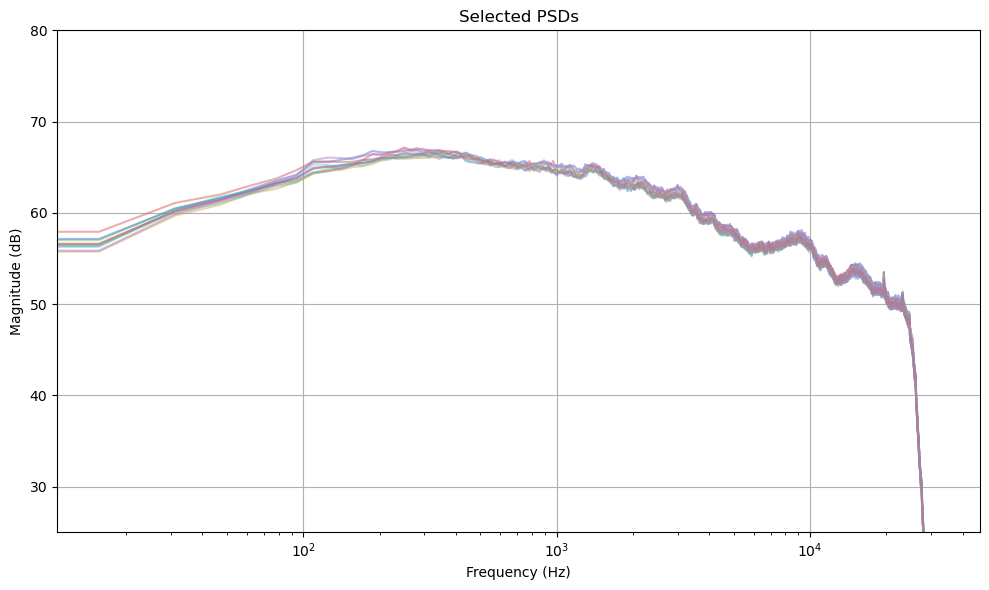

In [7]:
# Optional: set figure size and style
plt.figure(figsize=(10, 6))
#plt.style.use('seaborn-v0_8-muted')

# Plot selected PSDs
for i, row in df[0:10].iterrows():
    freq = row['frequency']
    psd = row['psd']
    
    if freq and psd:  # Make sure they're not empty
        plt.plot(freq, psd, alpha=0.5, label=f'{os.path.basename(row["file_path"])}')

# Set plot options
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Selected PSDs')
plt.ylim(25, 80)
plt.grid(True)

# Optional: show legend (can be crowded with many files)
# plt.legend()

plt.tight_layout()
plt.show()


# Plotting PSDs by Rain Rate and Wind Speed Range

Here, we group the data by rain rate and wind speed ranges and plot the corresponding PSDs. 

We define rain rate and wind speed bins and then plot a few PSDs from each category. This visualization helps identify trends, such as increased high-frequency noise during higher wind speeds due to surface agitation and bubble formation.

This section generates a plot similar to Figure 7 in [this paper](https://pubs.aip.org/asa/jasa/article/149/6/4579/1059394/Characterizing-underwater-noise-during-rain-at-the)

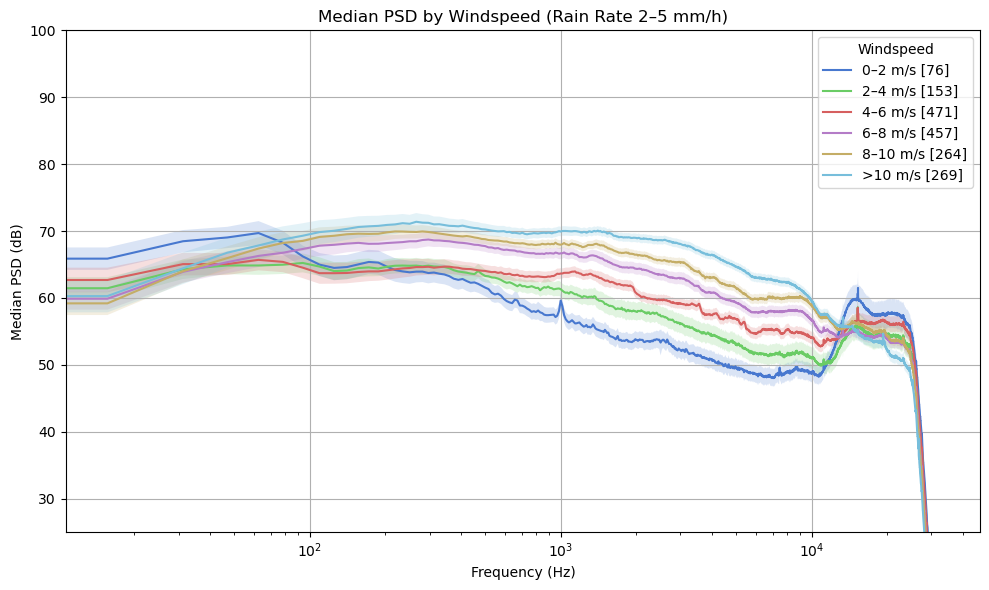

In [5]:
# Define windspeed categories as (label, min, max)
categories = [
    ('0–2 m/s', 0, 2),
    ('2–4 m/s', 2, 4),
    ('4–6 m/s', 4, 6),
    ('6–8 m/s', 6, 8),
    ('8–10 m/s', 8, 10),
    ('>10 m/s', 10, np.inf)
]

# Filter for rain rates between 2 and 5 mm/h
rain_filtered_df = df[(df['rainrate'] >= 2) & (df['rainrate'] <= 5)]

plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-muted')

for label, wmin, wmax in categories:
    # Filter rows in windspeed range within the rain-filtered subset
    group_df = rain_filtered_df[(rain_filtered_df['windspeed'] >= wmin) & (rain_filtered_df['windspeed'] < wmax)]

    # Collect aligned PSDs (same length and frequency)
    psd_list = []
    freq_ref = None

    for _, row in group_df.iterrows():
        freq = row['frequency']
        psd = row['psd']

        if freq and psd:
            if freq_ref is None:
                freq_ref = freq
            if len(freq) == len(freq_ref) and np.allclose(freq, freq_ref):
                psd_list.append(psd)

    # Calculate median and std if data is available
    if psd_list:
        psd_array = np.array(psd_list)
        median_psd = np.median(psd_array, axis=0)
        std_psd = np.std(psd_array, axis=0)
        
        # Plot median PSD line
        plt.plot(freq_ref, median_psd, label=label + f' [{len(psd_array)}]')

        # Plot shaded region for ±1/4 std deviation
        plt.fill_between(freq_ref, median_psd - std_psd/4, median_psd + std_psd/4, alpha=0.2)

# Final plot settings
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Median PSD (dB)')
plt.title('Median PSD by Windspeed (Rain Rate 2–5 mm/h)')
plt.ylim(25, 100)
plt.grid(True)
plt.legend(title='Windspeed')
plt.tight_layout()
plt.show()


Note: At low wind speeds, spectral levels during light rain and drizzle (with raindrop diameters < 1 mm) are dominated by a peak near 15 kHz. This peak arises from the damped oscillations of microbubbles formed by raindrop impacts. The formation of these microbubbles is highly dependent on wind conditions and diminishes rapidly when the raindrop impact angle deviates from vertical.

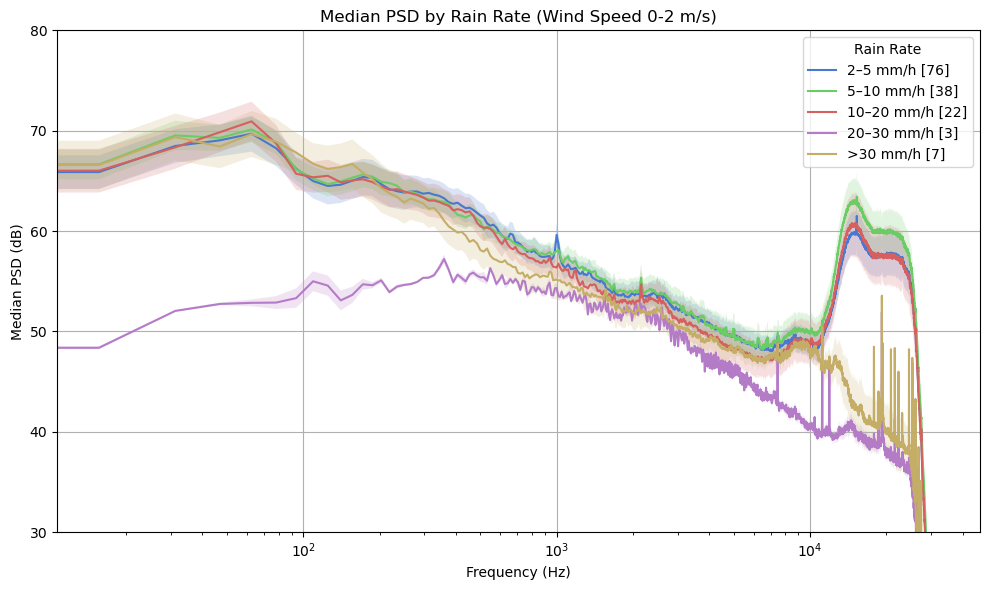

In [6]:
# Define rain rate categories as (label, min, max)
rain_categories = [
    ('2–5 mm/h', 2, 5),
    ('5–10 mm/h', 5, 10),
    ('10–20 mm/h', 10, 20),
    ('20–30 mm/h', 20, 30),
    ('>30 mm/h', 30, np.inf)
]

# Filter for wind speeds below 5 m/s
low_wind_df = df[(df['windspeed'] < 2) & (df['windspeed'] > 0)]

plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-muted')

for label, rmin, rmax in rain_categories:
    # Filter rows within rain rate range
    group_df = low_wind_df[(low_wind_df['rainrate'] >= rmin) & (low_wind_df['rainrate'] < rmax)]

    # Collect aligned PSDs (same length and frequency)
    psd_list = []
    freq_ref = None

    for _, row in group_df.iterrows():
        freq = row['frequency']
        psd = row['psd']

        if freq and psd:
            if freq_ref is None:
                freq_ref = freq
            if len(freq) == len(freq_ref) and np.allclose(freq, freq_ref):
                psd_list.append(psd)

    # Calculate and plot median PSD if available
    if psd_list:
        psd_array = np.array(psd_list)
        median_psd = np.median(psd_array, axis=0)
        std_psd = np.std(psd_array, axis=0)

        # Plot median line and shaded variability
        plt.plot(freq_ref, median_psd, label=label + f' [{len(psd_array)}]')
        plt.fill_between(freq_ref, median_psd - std_psd/4, median_psd + std_psd/4, alpha=0.2)

# Final plot settings
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Median PSD (dB)')
plt.title('Median PSD by Rain Rate (Wind Speed 0-2 m/s)')
plt.ylim(30, 80)
plt.grid(True)
plt.legend(title='Rain Rate')
plt.tight_layout()
plt.show()


At wind speeds below 4 m/s, spectral levels during light rain and drizzle (rain rates below 10 mm/h) are dominated by a prominent peak around 15 kHz, resulting from the damped oscillations of microbubbles generated by raindrop impacts.

## 🔍 Activity: Compare Oregon Offshore and Shelf Acoustic Data
Explore and compare underwater acoustic data recorded at two different locations off the Oregon coast: **Oregon offshore** and **Oregon shelf**. Analyze how environmental conditions, such as wind and rain, influence the acoustic spectra at each site.